# Prévisions météo en Australie

# Modélisation avec étape de ré-échantillonage

# Récupération des librairies

In [1]:
# récupération du package scikit-plot
!pip install scikit-plot

In [2]:
# récupération du package imblearn
!pip install --upgrade imblearn

Requirement already up-to-date: imblearn in /Users/gensteele/opt/anaconda3/lib/python3.8/site-packages (0.0)


In [18]:
# récupération des librairies
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

from scipy.spatial.distance import cdist
from scipy.stats import chi2_contingency

from sklearn import ensemble, linear_model, model_selection, neighbors, preprocessing, svm

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso, LassoCV, lasso_path, RidgeCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, mean_squared_error, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

# from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler

# Modèles de classification par apprentissage supervisé

In [6]:
# récuperation et aperçu du jeu de données après prétraitement, après l'étape de classification des villes en fonction 
# du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [7]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [8]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [9]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.777988
1    0.222012
Name: RainTomorrow, dtype: float64

In [10]:
# undersampling des données
rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print("Cardinalité des classes de la variable cible sous-échantillonnée:", dict(pd.Series(y_train_ru).value_counts()))

Cardinalité des classes de la variable cible sous-échantillonnée: {1: 25005, 0: 25005}


In [11]:
# distribution de la variable cible dans l'ensemble de test
y_train_ru.value_counts(normalize=True)

1    0.5
0    0.5
Name: RainTomorrow, dtype: float64

In [12]:
# standardisation des données
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Arbres de décision

In [13]:
# définition du modèle
clf_dt = DecisionTreeClassifier()

param_grid_dt = {'criterion' : ['entropy','gini'], 
                 'max_depth' : np.arange(2,6,1)}

gcv_dt = GridSearchCV(clf_dt, param_grid_dt)

In [14]:
start_time = time.time()

# entraînement
gcv_dt.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_dt.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_dt.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_dt.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_dt.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'criterion': 'gini', 'max_depth': 5} 

Accuracy Score: 0.839193124511684 

Train Data Score: 0.8386028465137754
Test Data Score: 0.839193124511684

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20825  1137
1             3391  2805
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     21962
           1       0.71      0.45      0.55      6196

    accuracy                           0.84     28158
   macro avg       0.79      0.70      0.73     28158
weighted avg       0.83      0.84      0.83     28158

Running Time: 0:00:16.032970


- la méthode des arbres de décision ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.73.
- la spécificité (taux de vrais négatifs) vaut 0.78.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.84).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.59).

In [15]:
# importance des variables
clf_dt = gcv_dt.best_estimator_
clf_dt.fit(X_train_scaled,y_train)

feats = {}
for feature, importance in zip(df.columns, clf_dt.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Humidity3pm,0.750954
WindGustSpeed,0.086579
Rainfall,0.058749
Sunshine,0.047818
Pressure9am,0.046689
clim_méditerranéen,0.003083
Humidity_Delta,0.002374
clim_chaud_humide,0.001898


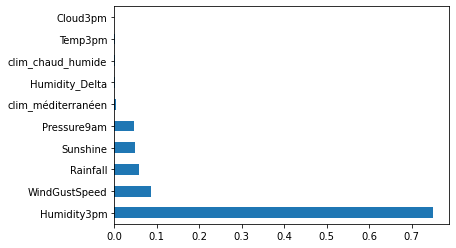

In [16]:
# importance des variables
feature_imp = pd.Series(clf_dt.feature_importances_,index=data.columns)
feature_imp.nlargest(10).plot(kind='barh');

In [17]:
cv_scores = cross_val_score(gcv_dt, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.83514903 0.83714674 0.83829209]
Average cross-validation score: 0.8368626197515737


- Le score de la méthode DT est en moyenne de : 0.84.

C'est clair que l'humidite est le variable le plus important dans ce modele. 

Decision Trees sont consideres comme 'white box' modeles au contraire des 'black box' modeles (e.g. neural networks), qui sont beaucoup plus difficile a interpreter. Nous pouvons visualiser le Decision Tree lui meme en utilisant plot_tree. La graphique d'un Decision Tree devient vite peu lisible avec un 'max-depth' de plus que 3. Ici nous allons presenter le graphique pour un modele reinitialise pour etre plus photogenique. A chaque noeud, la condition est tres claire, donc c'est facile de faire une prediction et la justifier.

In [22]:
# Retrain to have max-depth of 3 for visualisation purposes
clf_dt2 = DecisionTreeClassifier(max_depth=3)
clf_dt2.fit(X_train_scaled,y_train)

DecisionTreeClassifier(max_depth=3)

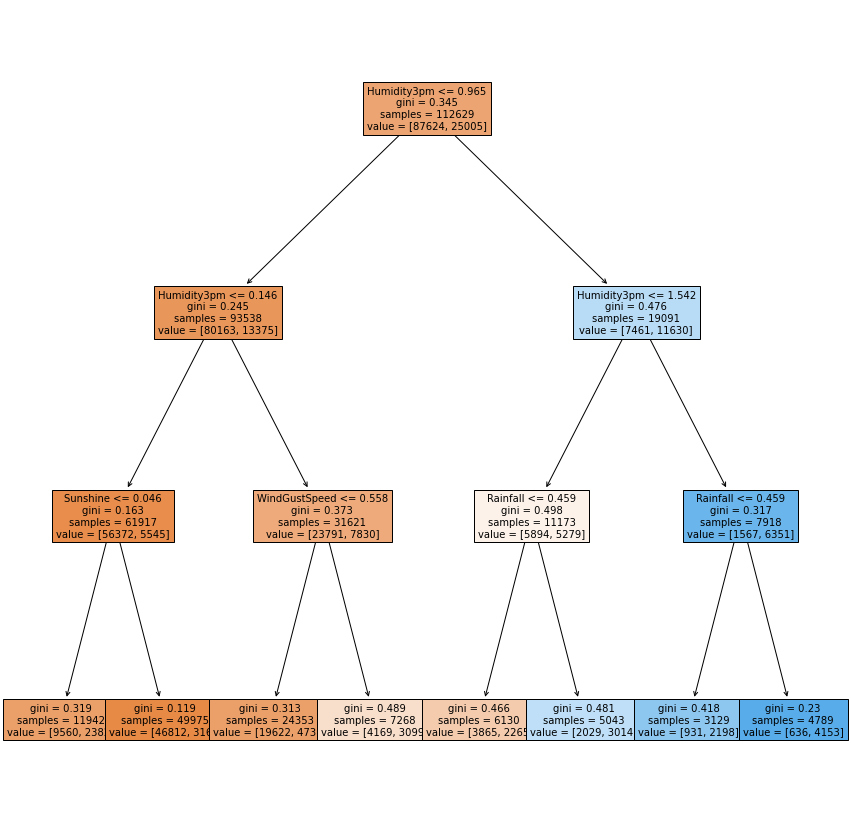

In [23]:
plt.figure(figsize=(15,15))
plot_tree(clf_dt2, feature_names = X_train.columns.tolist(), filled=True, fontsize = 10); #proportion=True

Un autre alternative pour expliquer tous les etapes dans un modele Decision Tree est de presenter le modele comme du pseudo-code mais qui est du "vrai" code. Voici une fonction pour faire ca.

In [24]:
#
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    """
    Visualise un DT comme code
    
    Parametres:
    -----------
    tree: decision tree model
    feature_names: list
    """

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [25]:
#apply fonction to simplified decision tree model
tree_to_code(clf_dt2, feature_names = X_train.columns.tolist())

def tree(Rainfall, Sunshine, WindGustSpeed, Humidity3pm, Pressure9am, Cloud3pm, Temp3pm, Temp_Delta_MinMax, Humidity_Delta, clim_chaud_humide, clim_méditerranéen, clim_sec, clim_tempéré_froid):
  if Humidity3pm <= 0.9646297097206116:
    if Humidity3pm <= 0.1463293693959713:
      if Sunshine <= 0.04559019394218922:
        return [[9560. 2382.]]
      else:  # if Sunshine > 0.04559019394218922
        return [[46812.  3163.]]
    else:  # if Humidity3pm > 0.1463293693959713
      if WindGustSpeed <= 0.5577304512262344:
        return [[19622.  4731.]]
      else:  # if WindGustSpeed > 0.5577304512262344
        return [[4169. 3099.]]
  else:  # if Humidity3pm > 0.9646297097206116
    if Humidity3pm <= 1.5422534942626953:
      if Rainfall <= 0.45916397869586945:
        return [[3865. 2265.]]
      else:  # if Rainfall > 0.45916397869586945
        return [[2029. 3014.]]
    else:  # if Humidity3pm > 1.5422534942626953
      if Rainfall <= 0.45916397869586945:
        return [[ 931. 2

In [26]:
#apply function to best fit model
tree_to_code(clf_dt, feature_names = X_train.columns.tolist())

def tree(Rainfall, Sunshine, WindGustSpeed, Humidity3pm, Pressure9am, Cloud3pm, Temp3pm, Temp_Delta_MinMax, Humidity_Delta, clim_chaud_humide, clim_méditerranéen, clim_sec, clim_tempéré_froid):
  if Humidity3pm <= 0.9646297097206116:
    if Humidity3pm <= 0.1463293693959713:
      if Sunshine <= 0.04559019394218922:
        if WindGustSpeed <= 1.0209693908691406:
          if Pressure9am <= -0.1737670674920082:
            return [[2637.  795.]]
          else:  # if Pressure9am > -0.1737670674920082
            return [[5435.  664.]]
        else:  # if WindGustSpeed > 1.0209693908691406
          if clim_méditerranéen <= 0.7172037661075592:
            return [[1337.  706.]]
          else:  # if clim_méditerranéen > 0.7172037661075592
            return [[151. 217.]]
      else:  # if Sunshine > 0.04559019394218922
        if WindGustSpeed <= 1.0209693908691406:
          if Humidity3pm <= -0.43129441142082214:
            return [[26751.   947.]]
          else:  # if Humidity3pm >

Le code pour le modele choisi est plus longue et a l'aire plus imposant mais ca reste facile a suivre.

De cette facon, avec quelques valeurs connues en entree, l'utilsateur humain peut facilement trouver la probabilite en sortie.